In [8]:
exec(open("notebooks/Crosswalk-area/init_notebook.py", "r").read())
%load_ext autoreload
%autoreload 2

current working dirC:\Users\ryanc\Documents\UCSC\carla-jaywalker-experiments
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from shapely.geometry import Polygon, Point, LineString
from shapely.affinity import rotate
import matplotlib.pyplot as plt
import math
import random
import seaborn as sb
# from agents.pedestrians.destination import CrosswalkGeometry

In [17]:

class CrosswalkGeometry:
    '''
    Geometric information of CrosswalkModel, including source, idealDestination, areaPolygon, and goalLine.

    CONSTANTS:
        MAX_ABSOLUTE_DEGREE: float
        MAX_RELATIVE_DEGREE: float
        INTER_POINTS_NUM: int
        INTER_POINTS_DISTANCE_MOD: float
    '''
    MAX_ABSOLUTE_DEGREE = math.radians(60)
    MAX_RELATIVE_DEGREE = math.radians(45)
    INTER_POINTS_NUM = 3
    INTER_POINTS_DISTANCE_MOD = 1.5

    def __init__(self, source: Point, idealDestination: Point=None, areaPolygon: Polygon=None, goalLine: LineString=None):
        self.source = source
        self.idealDestination = idealDestination
        self.areaPolygon = areaPolygon
        self.goalLine = goalLine
        self.intermediatePoints = []
        self.finalDestination = None
        self.nextIntermediatePointIdx = None
        if self.areaPolygon == None:
            self.createPolygonIfNone()
        self.generateIntermediatePoints()
    
    def createPolygonIfNone(self):
        # TODO: we make a generic one which may be based on real world dataset. Also create a goal line
        if self.goalLine == None:
            self.createGoalLine(4)
       
        self.areaPolygon = self.genPolyArea(self.source, self.idealDestination, self.goalLine)


    def genPolyArea(self, start: Point, end: Point, goalLine: LineString):
        '''
        Generate a generic areaPolygon given a start point, end point and a goalLine.
        
        Args:
            start (shapely.geometry.Point): the point where the pedestrian enters the crosswalk.
            end (shapely.geometry.Point): the ideal point where the pedestrian exits the crosswalk.
            goalLine (shapely.geometry.LineString): the sidewalk which contains the end point.

        Returns:
            areaPolygon (shapely.geometry.Polygon): the generated polygon that forms the area of an abstract crosswalk space.
        '''
        # Extract goalLine information
        goalLine_x1, goalLine_y1 = goalLine.coords[0][0], goalLine.coords[0][1] 
        goalLine_x2, goalLine_y2 = goalLine.coords[1][0], goalLine.coords[1][1]
        # Generate base as perpendicular to the vertical line
        
        if end is None:
            end = self.closestEnd(start, goalLine)
            
        verticalLine = LineString([start, end])
        baseRight = rotate(verticalLine, -90, origin=start)
        baseLeft = rotate(verticalLine, 90, origin=start)
        # Bottom left point
        botLeft = baseLeft.interpolate(0.5, normalized=False)
        botLeft_x = botLeft.coords[0][0]
        botLeft_y = botLeft.coords[0][1]
        # Bottom right point
        botRight = baseRight.interpolate(0.5, normalized=False)
        botRight_x = botRight.coords[0][0]
        botRight_y = botRight.coords[0][1]
        # Top left point
        topLeft_x = goalLine_x1
        topLeft_y = goalLine_y1
        topLeft = Point((topLeft_x, topLeft_y))
        # Top right point
        topRight_x = goalLine_x2
        topRight_y = goalLine_y2
        topRight = Point((topRight_x, topRight_y))
        # Mid left point
        midLeft_x = min(botLeft_x, topLeft_x) + (max(botLeft_x, topLeft_x) - min(botLeft_x, topLeft_x))/1.5
        midLeft_y = (topLeft_y - botLeft_y)/2
        midLeft = Point((midLeft_x, midLeft_y))
        # Mid right point
        midRight_x = min(botRight_x, topRight_x) + (max(botRight_x, topRight_x) - min(botRight_x, topRight_x))/3
        midRight_y = (topRight_y - botRight_y) / 2
        midRight = Point((midRight_x, midRight_y))

        # Build areaPolygon
        areaPolygon = Polygon([botLeft, midLeft, topLeft, topRight, midRight, botRight])
        return areaPolygon


    def generateIntermediatePoints(self, maxAbsDegree=MAX_ABSOLUTE_DEGREE, maxDeltaDegree=MAX_RELATIVE_DEGREE, nInterPoints=INTER_POINTS_NUM, maxInterPointsDistance=INTER_POINTS_DISTANCE_MOD):
        '''
        Generate intermediate points inside the crosswalk area to form pedestrian crossing trajectories. 

        Args:
            maxAbsDegree (float): the maximum degree between the new line and the vertical line that shares the same start point
            maxDeltaDegree (float): the maximum degree between the new line and the extended previous line. The end point of the previous line is the start point of the new line
            nInterPoints (int): the number of intermediates points to be generated
            maxInterPointsDistance (float): the scalar modifier for the max distance between any two intermediate points

        Returns:
            None
        '''
        start = self.source
        if self.idealDestination is None:
            # Find vertical line
            D_final = self.closestEnd(start, self.goalLine)
        else:
            D_final = self.idealDestination
        crosswalk = self.areaPolygon
        waypoints = [start]
        
        for i in range(nInterPoints):
            W_pre1 = waypoints[-1]
            W_pre2 = waypoints[-2] if len(waypoints) > 1 else None
            
            pointsOL = self.pointsOnLine(W_pre1, D_final, nInterPoints)
            A = pointsOL[1]
            B = pointsOL[2]
            # print(pointsOL)
            # print("W_pre1", W_pre1, "A", A, "B", B)
            done = False
            
            while not done:
                chance = random.choice([0, 1])
                C = self.pointBetween(A, B, d=random.uniform(0, 1)) # modify d if needed
                if chance == 0:
                    C = self.pointRotate(C, A, degree=90)
                    
                else:
                    C = self.pointRotate(C, A, degree=-90)
                    
                # Check constraints
                if crosswalk.contains(C):
                    # print(f"C, {C} inside the area")
                    lineAB = LineString([A, B])
                    line_W_pre1_C = LineString([W_pre1, C])
                    line_W_pre1_W_pre2 = None
                    if i > 0:
                        line_W_pre1_W_pre2 = LineString([W_pre2, W_pre1])
                    if line_W_pre1_C.length <= lineAB.length*maxInterPointsDistance:
                        # print(f"line_W_pre1_C.length, {line_W_pre1_C.length} is good")
                        if line_W_pre1_W_pre2 == None:
                            done = True
                        else:
                            # if the ideal destination is None, we are free to explore
                            
                            if self.idealDestination is None:
                                # Find vertical line
                                D_final = self.closestEnd(W_pre1, self.goalLine)
                                # print(f"ideal destination is None, D_final is {D_final}")
                            else:
                                D_final = self.idealDestination
                                
                            destinationLine = LineString([W_pre1, D_final])
                            
                            
                            # Calculate the angle between the new line and the vertical line
                            a_theta = self.degreeFromX(destinationLine) - self.degreeFromX(line_W_pre1_C)
                            # Calculate the angle between the new line and the extended previous line
                            d_theta = self.degreeFromX(line_W_pre1_W_pre2) - self.degreeFromX(line_W_pre1_C)
                        

                            if maxAbsDegree*(-1) <= a_theta <= maxAbsDegree and maxDeltaDegree*(-1) <= d_theta <= maxDeltaDegree:
                                done = True
                            # else:
                            #     print("a_theta", math.degrees(a_theta), "b_theta", math.degrees(d_theta))
                            #     waypoints.append(C)
                            #     print("returning to debug")
                            #     return waypoints
                    # else:
                    #     print(f"line_W_pre1_C.length, {line_W_pre1_C.length} is bad")
                    #     waypoints.append(C)
                    #     print("returning to debug")
                    #     return waypoints
                        
            
            # print(f"iteration-{i}, C, {C} satisfies the constraints")
            
            waypoints.append(C)
#             new_start = C
#             extend_end = new_line.interpolate(10, normalized=True)
#             new_end = self.closestEnd(extend_end, self.goalLine)
            
#             pointsOL = self.pointsOnLine(new_start, new_end, nInterPoints-(i+1))

        # final rotate to find end point is different
    
        if self.idealDestination is not None:
            # Find vertical line
            waypoints.append(self.idealDestination)
        else:
        
            D_final = self.closestEnd(W_pre1, self.goalLine)

            # Final destination point works in the reversed direction. We get the D_final and ...

            final_start = D_final
            final_end = waypoints[-1]
            done = False
            while not done:
                C = self.pointBetween(final_start, final_end, d=random.uniform(0, 1))
                chance = random.random()
                if chance > 0.5:
                    C = self.pointRotate(C, final_start, degree=90)
                else:
                    C = self.pointRotate(C, final_start, degree=-90)

                segment = LineString([final_start, final_end])
                line_W_pre1_C = LineString([waypoints[-1], C])
                line_W_pre1_W_pre2 = LineString([waypoints[-2], waypoints[-1]])
                if line_W_pre1_C.length <= segment.length*maxInterPointsDistance:
                    # Find vertical line
                    vert_start = waypoints[-1]
                    vert_end = self.closestEnd(vert_start, self.goalLine)
                    destinationLine = LineString([vert_start, vert_end])
                    # Calculate the angle between the new line and the vertical line
                    a_theta = self.degreeFromX(destinationLine) - self.degreeFromX(line_W_pre1_C)
                    # Calculate the angle between the new line and the extended previous line
                    d_theta = self.degreeFromX(line_W_pre1_W_pre2) - self.degreeFromX(line_W_pre1_C)

                    if abs(a_theta) <= maxAbsDegree and abs(d_theta) <= maxDeltaDegree:
                        done = True

            if self.goalLine.contains(C) == False:
                C = self.closestEnd(C, self.goalLine)
            waypoints.append(C)
            
        # 1. set intermediatePoints[] to the generated waypoints[]
        self.intermediatePoints = waypoints[1:]

        # 2. set nextIntermediatePointIdx to index 0
        self.nextIntermediatePointIdx = 0

        # 3. set self.finalDestination to the last item in waypoints[]
        self.finalDestination = waypoints[-1]

        return self.intermediatePoints




    # region 
    def degreeFromX(self, line: LineString): # TODO move to lib/Geometry
        """
        Find the angle in radian between a given line and the x-axis.
        
        Args:
            line (shapely.LineString): a line

        Returns:
            theta (float): angle in radians
        """
        # Extract points from line1 and line2
        x = line.coords[1][0] - line.coords[0][0]
        y = line.coords[1][1] - line.coords[0][1]

        # Find theta using formula
        theta = math.atan2(y, x)

        return theta

    def closestEnd(self, point: Point, goalLine: LineString):
        """
        Given a point A and a line Y, find the point B on Y such that the line AB is the shortest.

        Args:
            point (shapely.geometry.Point): point A
            goalLine (shapely.geometry.LineString): line Y

        Returns:
            end (shapely.geometry.Point): point B
        """
        d = goalLine.project(point)
        end = goalLine.interpolate(d)
        return end

    def pointBetween(self, start: Point, end: Point, d: float):
        """
        Given point A and point B, find a point C in between AB that is d distance away from A.
        
        Args:
            start (shapely.geometry.Point): point A
            end (shapely.geometry.Point): point B
            d (float): a scalar multiplier to the normalized distance between point A and point B

        Returns:
            point (shapely.geometry.Point): point C
        """
        line = LineString([start, end])
        point = line.interpolate(d, normalized=True)
        return point

    def pointRotate(self, point: Point, origin: Point, degree=90):
        """
        Given a point A and an origin O, rotate A +-90 degrees around O to get point B.

        Args:
            point (shapely.geometry.Point): point A
            origin (shapely.geometry.Point): point O
            degree (int, optional): degree of rotation. Defaults to 90

        Returns:
            rotated_point (shapely.geometry.Point): point B
        """
        rotated_point = rotate(point, degree, origin=origin)
        return rotated_point

    def pointsOnLine(self, start: Point, end: Point, n: int, excludeEnds=False):
        """
        Given a start point A and an end point B, generate n number of evenly spaced points between the line AB.

        Args:
            start (shapely.geometry.Point): point A
            end (shapely.geometry.Point): point B
            n (int): number of points between the line AB

        Returns:
            pointsOL[(shapely.geometry.Point)]: the array of generated points between AB
        """
        pointsOL = [start]
        line = LineString([start, end])
        gap = 1 / (n)
        d = gap
        for i in range(n):
            point = line.interpolate(d, normalized=True)
            d = d + gap
            pointsOL.append(point)
        pointsOL.append(end)
        
        # print("pointsOL", pointsOL)
        
        if excludeEnds:
            # print("pointsOL", pointsOL)
            # for p in pointsOL:
            #     print(p)
            return pointsOL[1:len(pointsOL)-1]
        return pointsOL
    # endregion

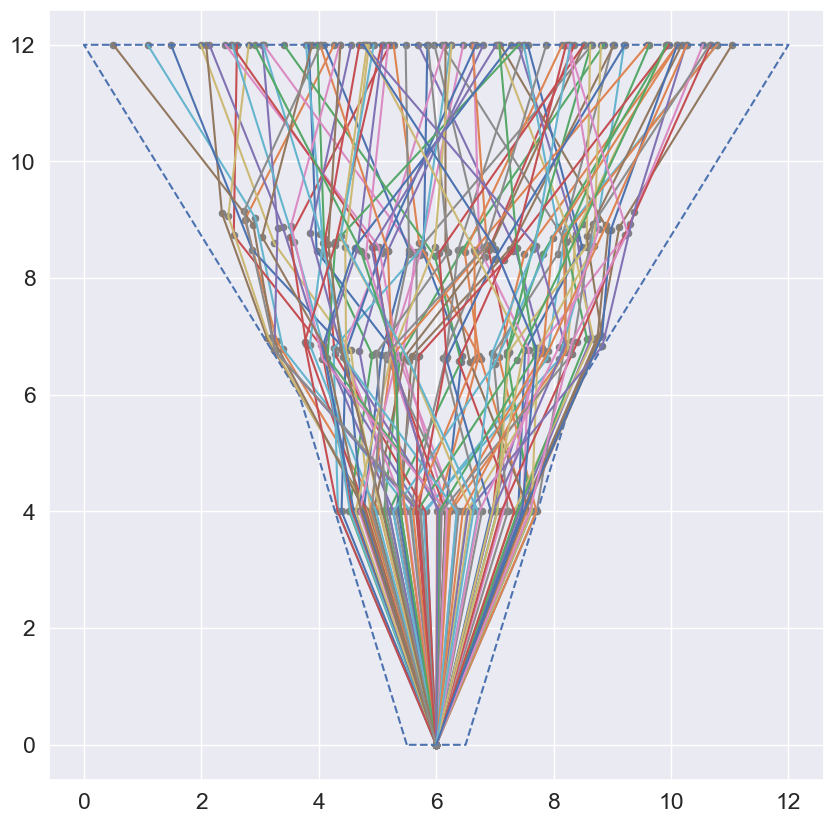

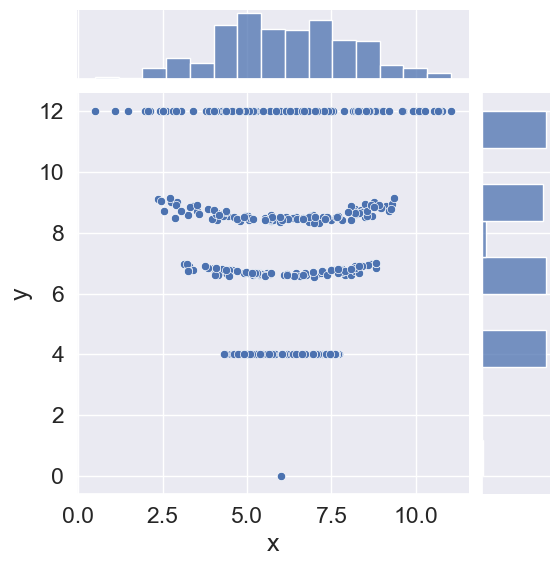

In [56]:
# Case 1.1: generic WITHOUT ideal destination point
# Plot polygons and points
goalLine = LineString([(0, 12), (12, 12)])
start = Point(6, 0)
end = Point(6, 12)
p = None
nIntermediate = 3

crosswalkGeometry = CrosswalkGeometry(
            source=start,
            idealDestination=None,
            areaPolygon=p,
            goalLine=goalLine
        )


# Case 1.1 figures
generic_p = crosswalkGeometry.areaPolygon
data = {'x': [], 'y': []}

p = crosswalkGeometry.areaPolygon
x,y = p.exterior.xy

plt.rcParams["figure.figsize"] = (10,10)
plt.plot(x,y, '--')
# plt.scatter(end.x, end.y, s=100, color='green')

maxAbsDegree = math.radians(60)
maxDeltaDegree = math.radians(45)

for i in range(100):
    line_x = []
    line_y = []
    waypoints = crosswalkGeometry.generateIntermediatePoints(maxAbsDegree, maxDeltaDegree, nIntermediate, 1.5)
    
    waypoints.insert(0, start)
    

    for j in range(len(waypoints)):
        line_x.append(waypoints[j].x)
        line_y.append(waypoints[j].y)

        if waypoints[j].y != start.y:
            data['x'].append(waypoints[j].x)
            data['y'].append(waypoints[j].y)

        plt.scatter(waypoints[j].x, waypoints[j].y, s=20, color='grey')
        

    plt.plot(line_x, line_y)

plt.savefig("notebooks/Crosswalk-area/figures/generic_noID_sc.png")

# Visualizing data
data['x'].append(start.x)
data['y'].append(start.y)
fig = sb.jointplot(data=data, x='x', y='y')
fig.savefig("notebooks/Crosswalk-area/figures/generic_noID_jp.png")

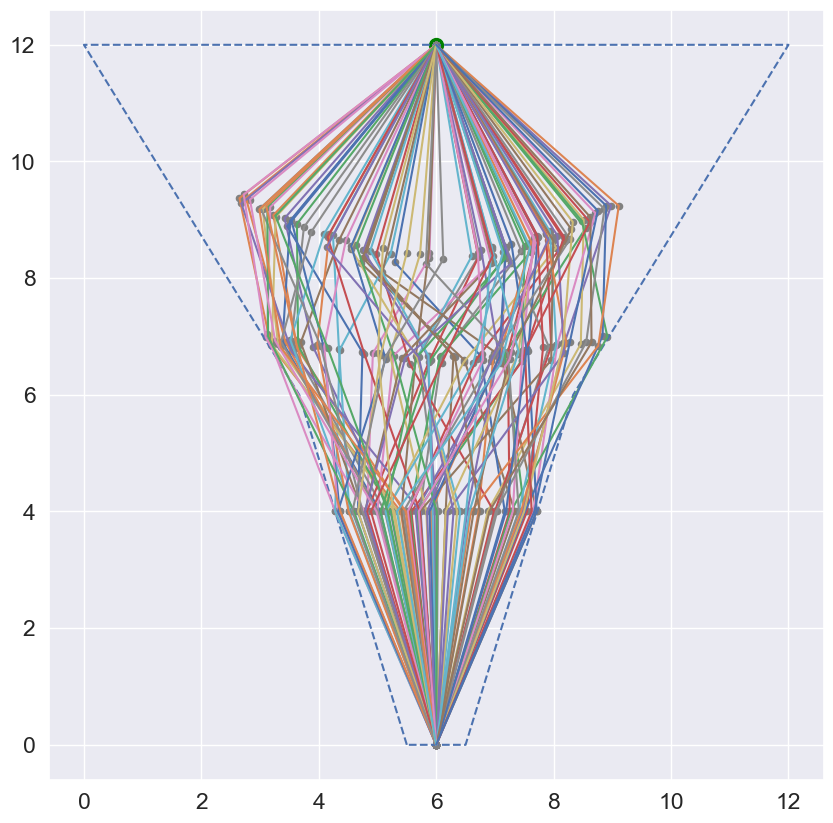

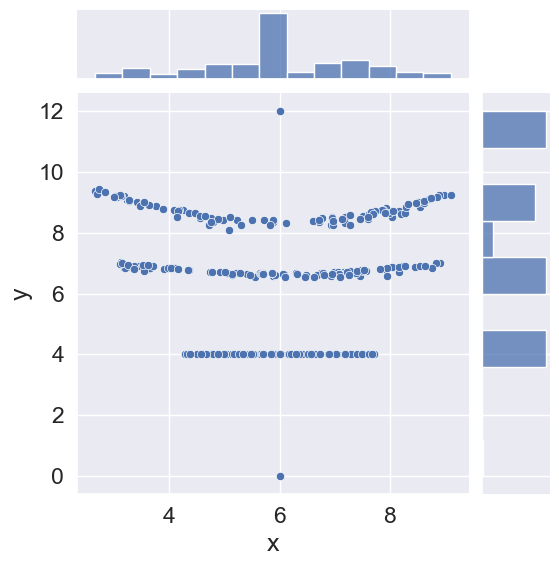

In [40]:
# Case 1.2: generic WITH ideal destination point
# Plot polygons and points
goalLine = LineString([(0, 12), (12, 12)])
start = Point(6, 0)
end = Point(6, 12)
p = None
nIntermediate = 3

crosswalkGeometry = CrosswalkGeometry(
            source=start,
            idealDestination=end,
            areaPolygon=p,
            goalLine=goalLine
        )

# Case 1.2 figures
data = {'x': [], 'y': []}

p = crosswalkGeometry.areaPolygon
x,y = p.exterior.xy

plt.rcParams["figure.figsize"] = (10,10)
plt.plot(x,y, '--')
plt.scatter(end.x, end.y, s=100, color='green')

maxAbsDegree = math.radians(60)
maxDeltaDegree = math.radians(45)

for i in range(100):
    line_x = []
    line_y = []
    waypoints = crosswalkGeometry.generateIntermediatePoints(maxAbsDegree, maxDeltaDegree, nIntermediate, 1.5)
    
    waypoints.insert(0, start)
    

    for j in range(len(waypoints)):
        line_x.append(waypoints[j].x)
        line_y.append(waypoints[j].y)

        if waypoints[j].y != start.y:
            data['x'].append(waypoints[j].x)
            data['y'].append(waypoints[j].y)

        plt.scatter(waypoints[j].x, waypoints[j].y, s=20, color='grey')
        

    plt.plot(line_x, line_y)

plt.savefig("notebooks/Crosswalk-area/figures/generic_withID_sc.png")

# Visualizing data
data['x'].append(start.x)
data['y'].append(start.y)
fig = sb.jointplot(data=data, x='x', y='y')
fig.savefig("notebooks/Crosswalk-area/figures/generic_withID_jp.png")

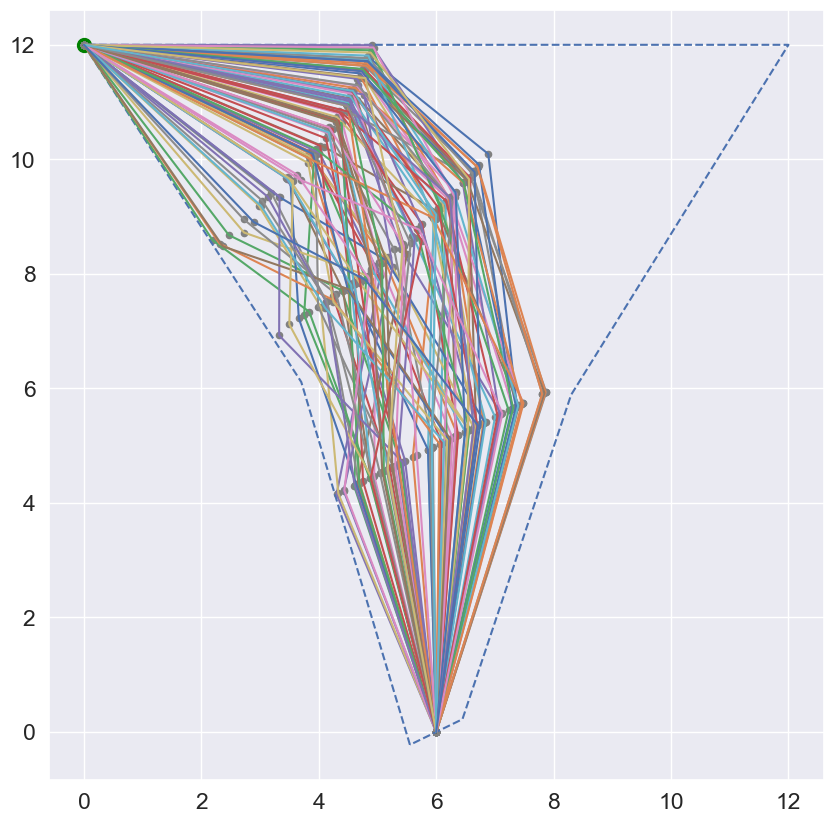

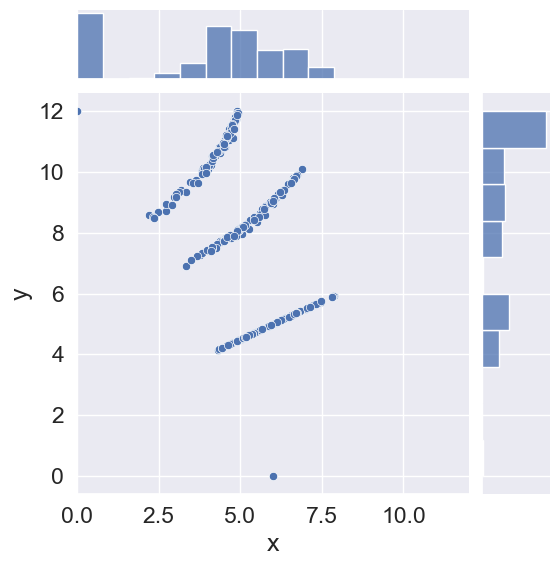

In [38]:
# Case 2.1: multiple ideal destination point
# Plot polygons and points
goalLine = LineString([(0, 12), (12, 12)])
start = Point(6, 0)
endPoints = [Point(0, 12), Point(3, 12), Point(6, 12), Point(9, 12), Point(12, 12)]
end = Point(6, 12)
p = None
nIntermediate = 3

crosswalkGeometry = CrosswalkGeometry(
            source=start,
            idealDestination=endPoints[0],
            areaPolygon=p,
            goalLine=goalLine
        )

# Case 2.1 figures
data = {'x': [], 'y': []}

p = crosswalkGeometry.areaPolygon
x,y = p.exterior.xy

plt.rcParams["figure.figsize"] = (10,10)
plt.plot(x,y, '--')
       
plt.scatter(endPoints[0].x, endPoints[0].y, s=100, color='green')

maxAbsDegree = math.radians(60)
maxDeltaDegree = math.radians(45)

for i in range(100):
    line_x = []
    line_y = []
    waypoints = crosswalkGeometry.generateIntermediatePoints(maxAbsDegree, maxDeltaDegree, nIntermediate, 1.5)
    
    waypoints.insert(0, start)
    

    for j in range(len(waypoints)):
        line_x.append(waypoints[j].x)
        line_y.append(waypoints[j].y)

        if waypoints[j].y != start.y:
            data['x'].append(waypoints[j].x)
            data['y'].append(waypoints[j].y)

        plt.scatter(waypoints[j].x, waypoints[j].y, s=20, color='grey')
        

    plt.plot(line_x, line_y)

plt.savefig("notebooks/Crosswalk-area/figures/case_21_sc.png")
# Visualizing data
data['x'].append(start.x)
data['y'].append(start.y)
fig = sb.jointplot(data=data, x='x', y='y', xlim=[0, 12])
fig.savefig("notebooks/Crosswalk-area/figures/case_21_jp.png")

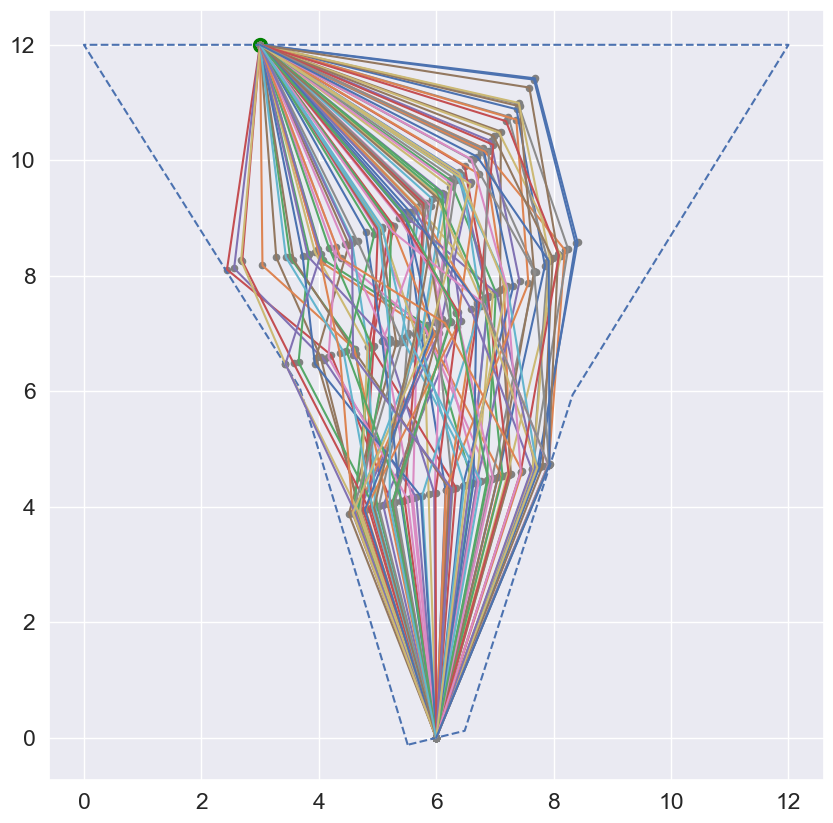

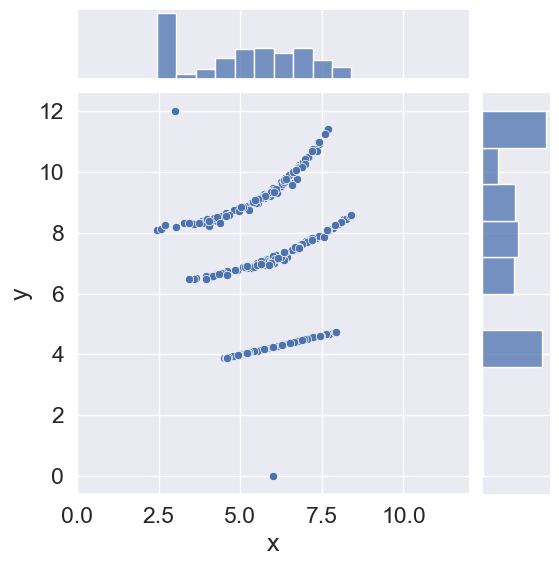

In [41]:
# Case 2.2: multiple ideal destination point
# Plot polygons and points
goalLine = LineString([(0, 12), (12, 12)])
start = Point(6, 0)
endPoints = [Point(0, 12), Point(3, 12), Point(6, 12), Point(9, 12), Point(12, 12)]
end = Point(6, 12)
p = None
nIntermediate = 3

crosswalkGeometry = CrosswalkGeometry(
            source=start,
            idealDestination=endPoints[1],
            areaPolygon=p,
            goalLine=goalLine
        )

# Case 2.2 figures
data = {'x': [], 'y': []}

p = crosswalkGeometry.areaPolygon
x,y = p.exterior.xy

plt.rcParams["figure.figsize"] = (10,10)
plt.plot(x,y, '--')
       
plt.scatter(endPoints[1].x, endPoints[1].y, s=100, color='green')

maxAbsDegree = math.radians(60)
maxDeltaDegree = math.radians(45)

for i in range(100):
    line_x = []
    line_y = []
    waypoints = crosswalkGeometry.generateIntermediatePoints(maxAbsDegree, maxDeltaDegree, nIntermediate, 1.5)
    
    waypoints.insert(0, start)
    

    for j in range(len(waypoints)):
        line_x.append(waypoints[j].x)
        line_y.append(waypoints[j].y)

        if waypoints[j].y != start.y:
            data['x'].append(waypoints[j].x)
            data['y'].append(waypoints[j].y)

        plt.scatter(waypoints[j].x, waypoints[j].y, s=20, color='grey')
        

    plt.plot(line_x, line_y)

plt.savefig("notebooks/Crosswalk-area/figures/case_22_sc.png")
# Visualizing data
data['x'].append(start.x)
data['y'].append(start.y)
fig = sb.jointplot(data=data, x='x', y='y', xlim=[0, 12])
fig.savefig("notebooks/Crosswalk-area/figures/case_22_jp.png")

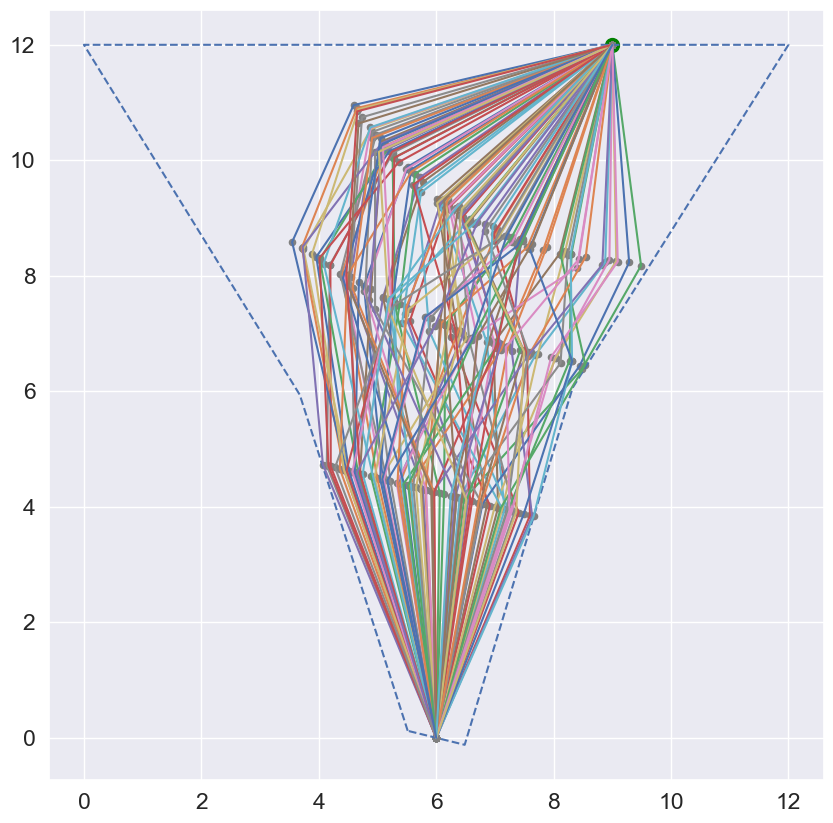

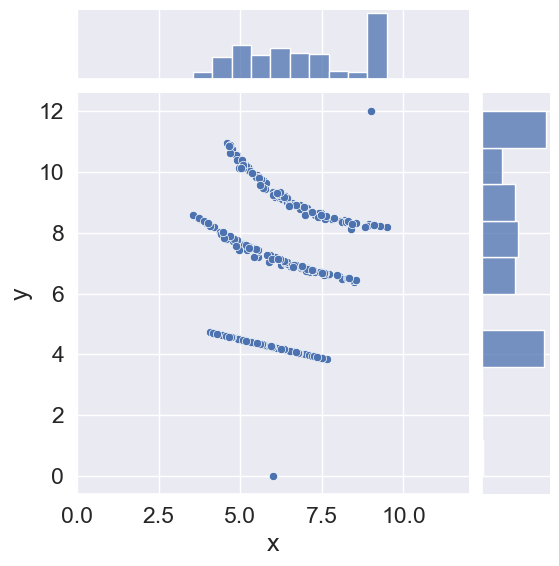

In [42]:
# Case 2.3: multiple ideal destination point
# Plot polygons and points
goalLine = LineString([(0, 12), (12, 12)])
start = Point(6, 0)
endPoints = [Point(0, 12), Point(3, 12), Point(6, 12), Point(9, 12), Point(12, 12)]
end = Point(6, 12)
p = None
nIntermediate = 3

crosswalkGeometry = CrosswalkGeometry(
            source=start,
            idealDestination=endPoints[3],
            areaPolygon=p,
            goalLine=goalLine
        )

# Case 2.3 figures
data = {'x': [], 'y': []}

p = crosswalkGeometry.areaPolygon
x,y = p.exterior.xy

plt.rcParams["figure.figsize"] = (10,10)
plt.plot(x,y, '--')
       
plt.scatter(endPoints[3].x, endPoints[3].y, s=100, color='green')

maxAbsDegree = math.radians(60)
maxDeltaDegree = math.radians(45)

for i in range(100):
    line_x = []
    line_y = []
    waypoints = crosswalkGeometry.generateIntermediatePoints(maxAbsDegree, maxDeltaDegree, nIntermediate, 1.5)
    
    waypoints.insert(0, start)
    

    for j in range(len(waypoints)):
        line_x.append(waypoints[j].x)
        line_y.append(waypoints[j].y)

        if waypoints[j].y != start.y:
            data['x'].append(waypoints[j].x)
            data['y'].append(waypoints[j].y)

        plt.scatter(waypoints[j].x, waypoints[j].y, s=20, color='grey')
        

    plt.plot(line_x, line_y)

plt.savefig("notebooks/Crosswalk-area/figures/case_23_sc.png")
# Visualizing data
data['x'].append(start.x)
data['y'].append(start.y)
fig = sb.jointplot(data=data, x='x', y='y', xlim=[0, 12])
fig.savefig("notebooks/Crosswalk-area/figures/case_23_jp.png")

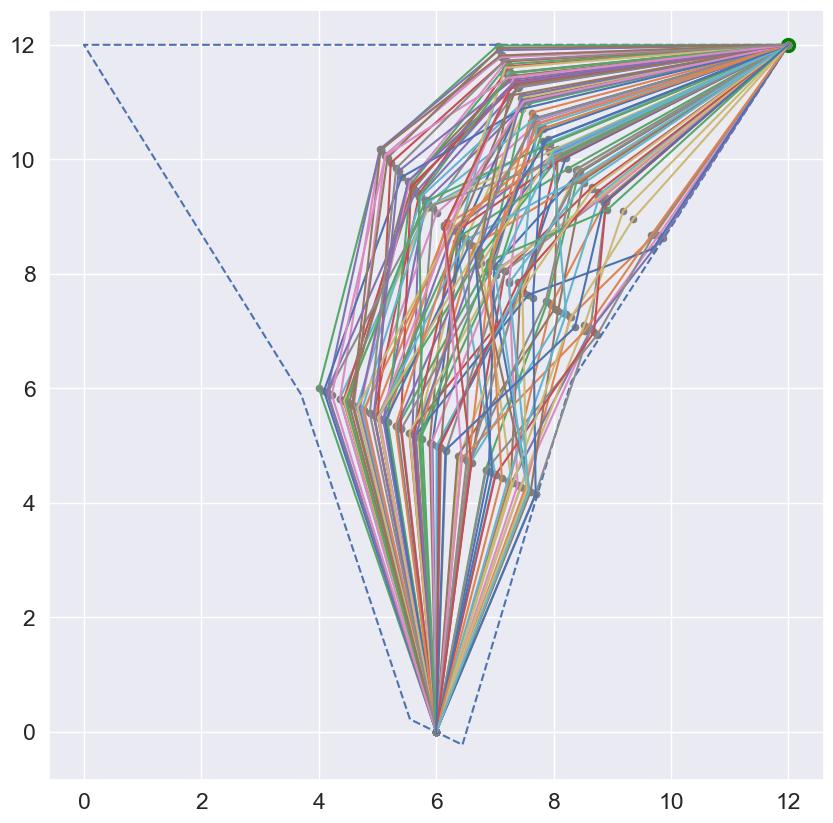

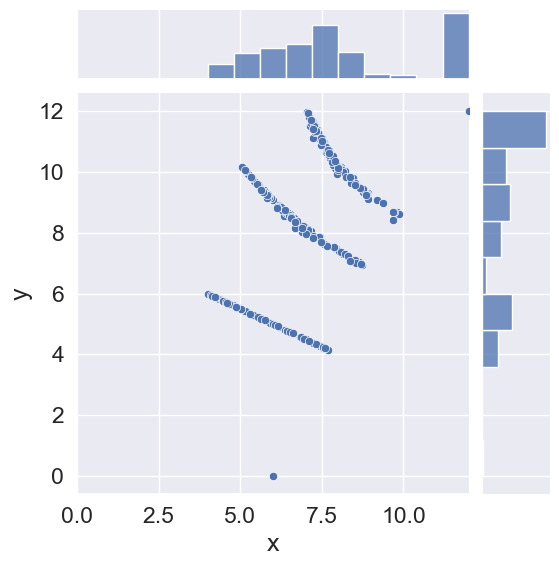

In [44]:
# Case 2.4: multiple ideal destination point
# Plot polygons and points
goalLine = LineString([(0, 12), (12, 12)])
start = Point(6, 0)
endPoints = [Point(0, 12), Point(3, 12), Point(6, 12), Point(9, 12), Point(12, 12)]
end = Point(6, 12)
p = None
nIntermediate = 3

crosswalkGeometry = CrosswalkGeometry(
            source=start,
            idealDestination=endPoints[4],
            areaPolygon=p,
            goalLine=goalLine
        )

# Case 2.4 figures
data = {'x': [], 'y': []}

p = crosswalkGeometry.areaPolygon
x,y = p.exterior.xy

plt.rcParams["figure.figsize"] = (10,10)
plt.plot(x,y, '--')
       
plt.scatter(endPoints[4].x, endPoints[4].y, s=100, color='green')

maxAbsDegree = math.radians(60)
maxDeltaDegree = math.radians(45)

for i in range(100):
    line_x = []
    line_y = []
    waypoints = crosswalkGeometry.generateIntermediatePoints(maxAbsDegree, maxDeltaDegree, nIntermediate, 1.5)
    
    waypoints.insert(0, start)
    

    for j in range(len(waypoints)):
        line_x.append(waypoints[j].x)
        line_y.append(waypoints[j].y)

        if waypoints[j].y != start.y:
            data['x'].append(waypoints[j].x)
            data['y'].append(waypoints[j].y)

        plt.scatter(waypoints[j].x, waypoints[j].y, s=20, color='grey')
        

    plt.plot(line_x, line_y)

plt.savefig("notebooks/Crosswalk-area/figures/case_24_sc.png")
# Visualizing data
data['x'].append(start.x)
data['y'].append(start.y)
fig = sb.jointplot(data=data, x='x', y='y', xlim=[0, 12])
fig.savefig("notebooks/Crosswalk-area/figures/case_24_jp.png")

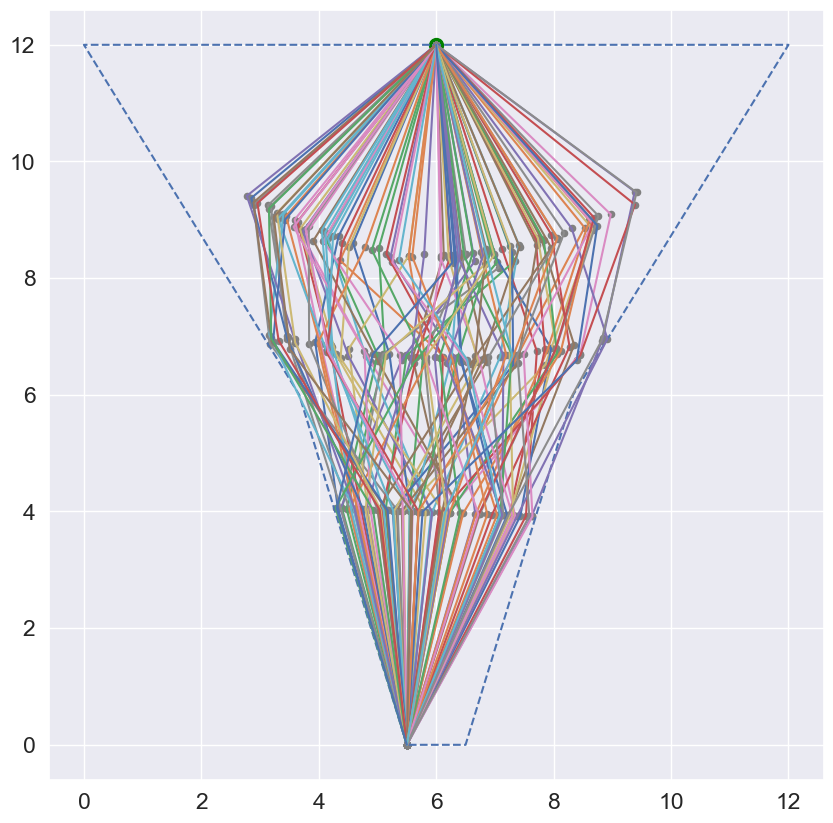

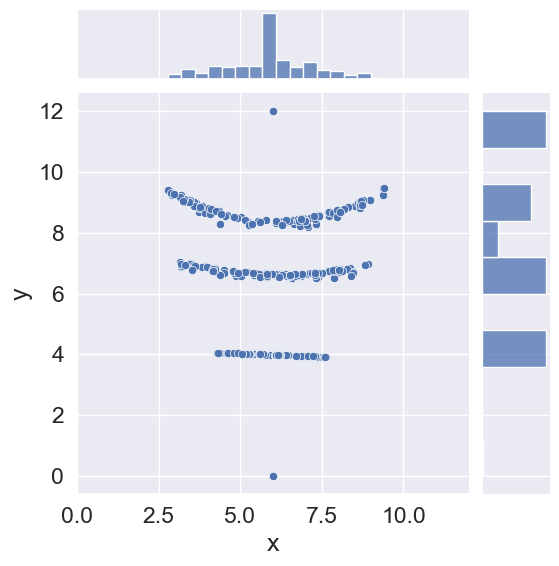

In [58]:
# Case 3.1.1: multiple source point with ID
# Plot polygons and points
goalLine = LineString([(0, 12), (12, 12)])
sourcePoints = [Point(5.5, 0), Point(5.75, 0), Point(6, 0), Point(6.25, 0), Point(6.5, 0)]
end = Point(6, 12)
p = generic_p
nIntermediate = 3

crosswalkGeometry = CrosswalkGeometry(
            source=sourcePoints[0],
            idealDestination=end,
            areaPolygon=p,
            goalLine=goalLine
        )

# Case 3.1.1 figures
data = {'x': [], 'y': []}

p = crosswalkGeometry.areaPolygon
x,y = p.exterior.xy

plt.rcParams["figure.figsize"] = (10,10)
plt.plot(x,y, '--')
       
plt.scatter(end.x, end.y, s=100, color='green')

maxAbsDegree = math.radians(60)
maxDeltaDegree = math.radians(45)

for i in range(100):
    line_x = []
    line_y = []
    waypoints = crosswalkGeometry.generateIntermediatePoints(maxAbsDegree, maxDeltaDegree, nIntermediate, 1.5)
    
    waypoints.insert(0, crosswalkGeometry.source)
    

    for j in range(len(waypoints)):
        line_x.append(waypoints[j].x)
        line_y.append(waypoints[j].y)

        if waypoints[j].y != start.y:
            data['x'].append(waypoints[j].x)
            data['y'].append(waypoints[j].y)

        plt.scatter(waypoints[j].x, waypoints[j].y, s=20, color='grey')
        

    plt.plot(line_x, line_y)

plt.savefig("notebooks/Crosswalk-area/figures/case_311_sc.png")
# Visualizing data
data['x'].append(start.x)
data['y'].append(start.y)
fig = sb.jointplot(data=data, x='x', y='y', xlim=[0, 12])
fig.savefig("notebooks/Crosswalk-area/figures/case_311_jp.png")



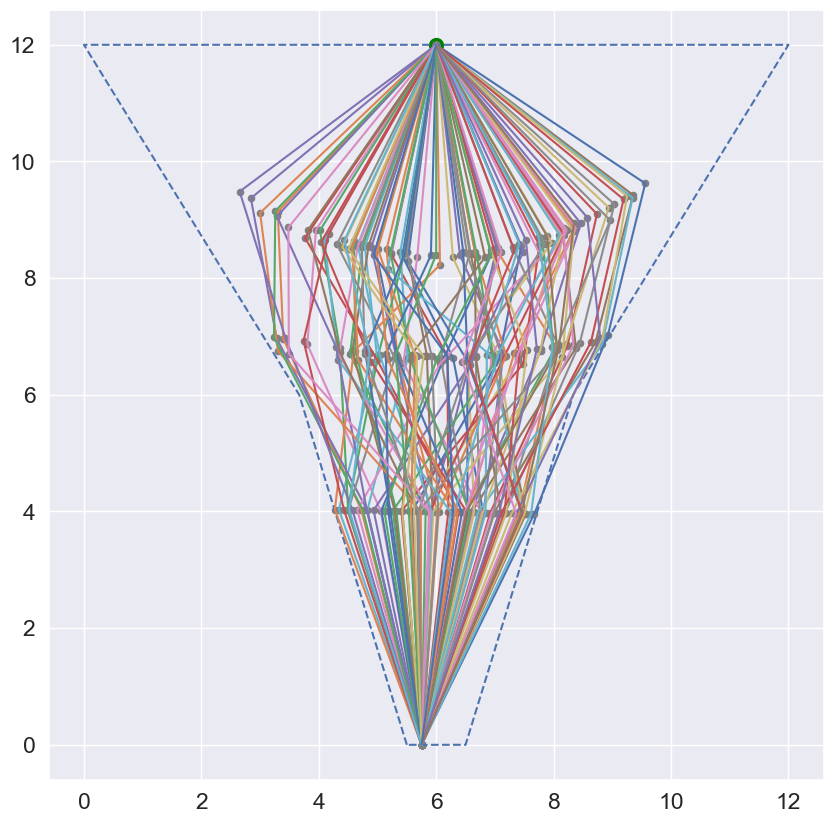

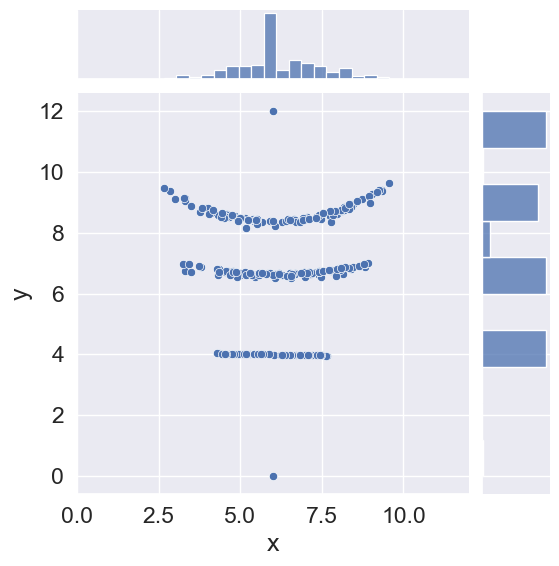

In [59]:
# Case 3.1.2: multiple source point with ID
# Plot polygons and points
goalLine = LineString([(0, 12), (12, 12)])
sourcePoints = [Point(5.5, 0), Point(5.75, 0), Point(6, 0), Point(6.25, 0), Point(6.5, 0)]
end = Point(6, 12)
p = generic_p
nIntermediate = 3

crosswalkGeometry = CrosswalkGeometry(
            source=sourcePoints[1],
            idealDestination=end,
            areaPolygon=p,
            goalLine=goalLine
        )

# Case 3.1.2 figures
data = {'x': [], 'y': []}

p = crosswalkGeometry.areaPolygon
x,y = p.exterior.xy

plt.rcParams["figure.figsize"] = (10,10)
plt.plot(x,y, '--')
       
plt.scatter(end.x, end.y, s=100, color='green')

maxAbsDegree = math.radians(60)
maxDeltaDegree = math.radians(45)

for i in range(100):
    line_x = []
    line_y = []
    waypoints = crosswalkGeometry.generateIntermediatePoints(maxAbsDegree, maxDeltaDegree, nIntermediate, 1.5)
    
    waypoints.insert(0, crosswalkGeometry.source)
    

    for j in range(len(waypoints)):
        line_x.append(waypoints[j].x)
        line_y.append(waypoints[j].y)

        if waypoints[j].y != start.y:
            data['x'].append(waypoints[j].x)
            data['y'].append(waypoints[j].y)

        plt.scatter(waypoints[j].x, waypoints[j].y, s=20, color='grey')
        

    plt.plot(line_x, line_y)

plt.savefig("notebooks/Crosswalk-area/figures/case_312_sc.png")
# Visualizing data
data['x'].append(start.x)
data['y'].append(start.y)
fig = sb.jointplot(data=data, x='x', y='y', xlim=[0, 12])
fig.savefig("notebooks/Crosswalk-area/figures/case_312_jp.png")



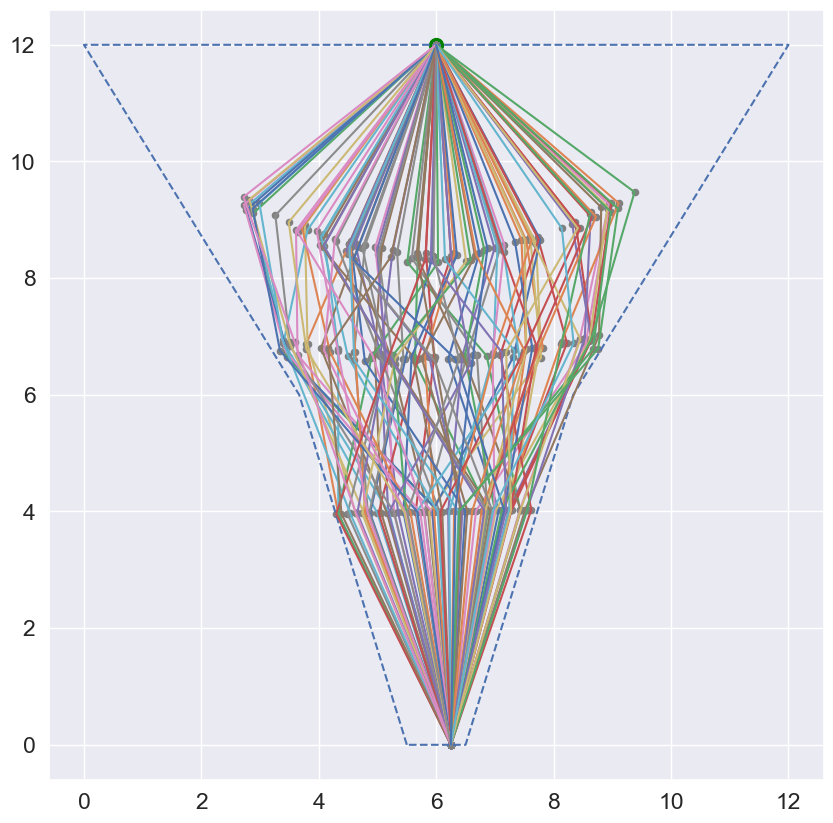

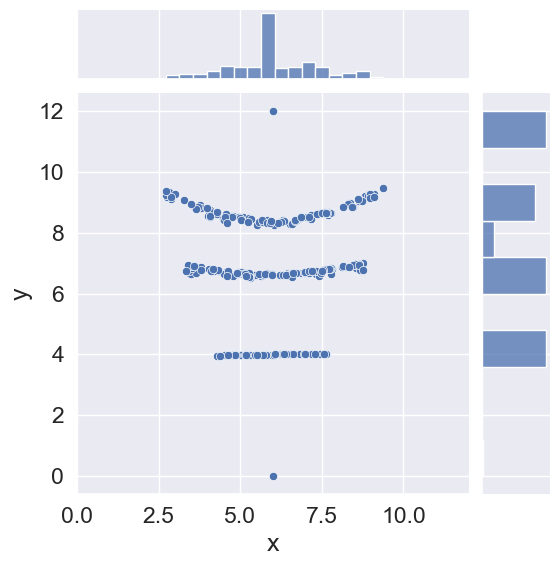

In [57]:
# Case 3.1.3: multiple source point with ID
# Plot polygons and points
goalLine = LineString([(0, 12), (12, 12)])
sourcePoints = [Point(5.5, 0), Point(5.75, 0), Point(6, 0), Point(6.25, 0), Point(6.5, 0)]
end = Point(6, 12)
p = generic_p
nIntermediate = 3

crosswalkGeometry = CrosswalkGeometry(
            source=sourcePoints[3],
            idealDestination=end,
            areaPolygon=p,
            goalLine=goalLine
        )

# Case 3.1.3 figures
data = {'x': [], 'y': []}

p = crosswalkGeometry.areaPolygon
x,y = p.exterior.xy

plt.rcParams["figure.figsize"] = (10,10)
plt.plot(x,y, '--')
       
plt.scatter(end.x, end.y, s=100, color='green')

maxAbsDegree = math.radians(60)
maxDeltaDegree = math.radians(45)

for i in range(100):
    line_x = []
    line_y = []
    waypoints = crosswalkGeometry.generateIntermediatePoints(maxAbsDegree, maxDeltaDegree, nIntermediate, 1.5)
    
    waypoints.insert(0, crosswalkGeometry.source)
    

    for j in range(len(waypoints)):
        line_x.append(waypoints[j].x)
        line_y.append(waypoints[j].y)

        if waypoints[j].y != start.y:
            data['x'].append(waypoints[j].x)
            data['y'].append(waypoints[j].y)

        plt.scatter(waypoints[j].x, waypoints[j].y, s=20, color='grey')
        

    plt.plot(line_x, line_y)

plt.savefig("notebooks/Crosswalk-area/figures/case_313_sc.png")
# Visualizing data
data['x'].append(start.x)
data['y'].append(start.y)
fig = sb.jointplot(data=data, x='x', y='y', xlim=[0, 12])
fig.savefig("notebooks/Crosswalk-area/figures/case_313_jp.png")



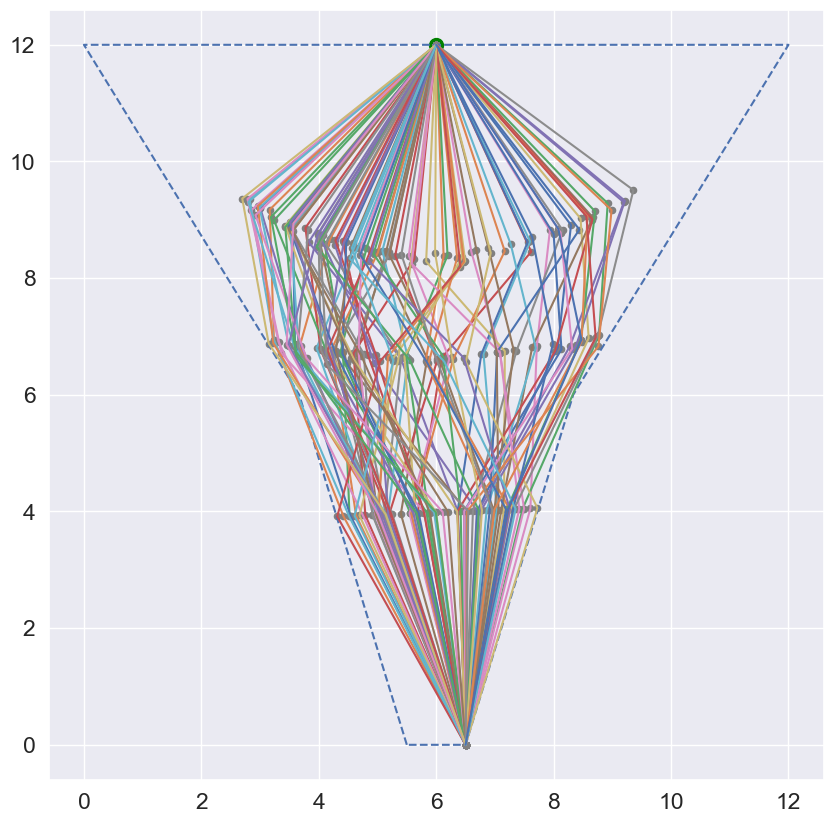

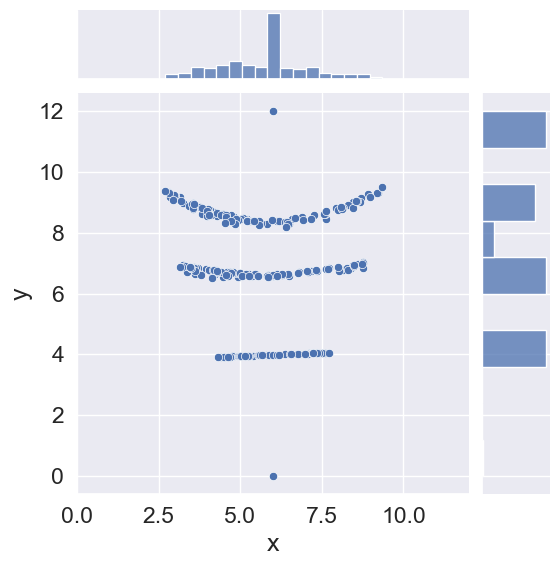

In [60]:
# Case 3.1.4: multiple source point with ID
# Plot polygons and points
goalLine = LineString([(0, 12), (12, 12)])
sourcePoints = [Point(5.5, 0), Point(5.75, 0), Point(6, 0), Point(6.25, 0), Point(6.5, 0)]
end = Point(6, 12)
p = generic_p
nIntermediate = 3

crosswalkGeometry = CrosswalkGeometry(
            source=sourcePoints[4],
            idealDestination=end,
            areaPolygon=p,
            goalLine=goalLine
        )

# Case 3.1.4 figures
data = {'x': [], 'y': []}

p = crosswalkGeometry.areaPolygon
x,y = p.exterior.xy

plt.rcParams["figure.figsize"] = (10,10)
plt.plot(x,y, '--')
       
plt.scatter(end.x, end.y, s=100, color='green')

maxAbsDegree = math.radians(60)
maxDeltaDegree = math.radians(45)

for i in range(100):
    line_x = []
    line_y = []
    waypoints = crosswalkGeometry.generateIntermediatePoints(maxAbsDegree, maxDeltaDegree, nIntermediate, 1.5)
    
    waypoints.insert(0, crosswalkGeometry.source)
    

    for j in range(len(waypoints)):
        line_x.append(waypoints[j].x)
        line_y.append(waypoints[j].y)

        if waypoints[j].y != start.y:
            data['x'].append(waypoints[j].x)
            data['y'].append(waypoints[j].y)

        plt.scatter(waypoints[j].x, waypoints[j].y, s=20, color='grey')
        

    plt.plot(line_x, line_y)

plt.savefig("notebooks/Crosswalk-area/figures/case_314_sc.png")
# Visualizing data
data['x'].append(start.x)
data['y'].append(start.y)
fig = sb.jointplot(data=data, x='x', y='y', xlim=[0, 12])
fig.savefig("notebooks/Crosswalk-area/figures/case_314_jp.png")



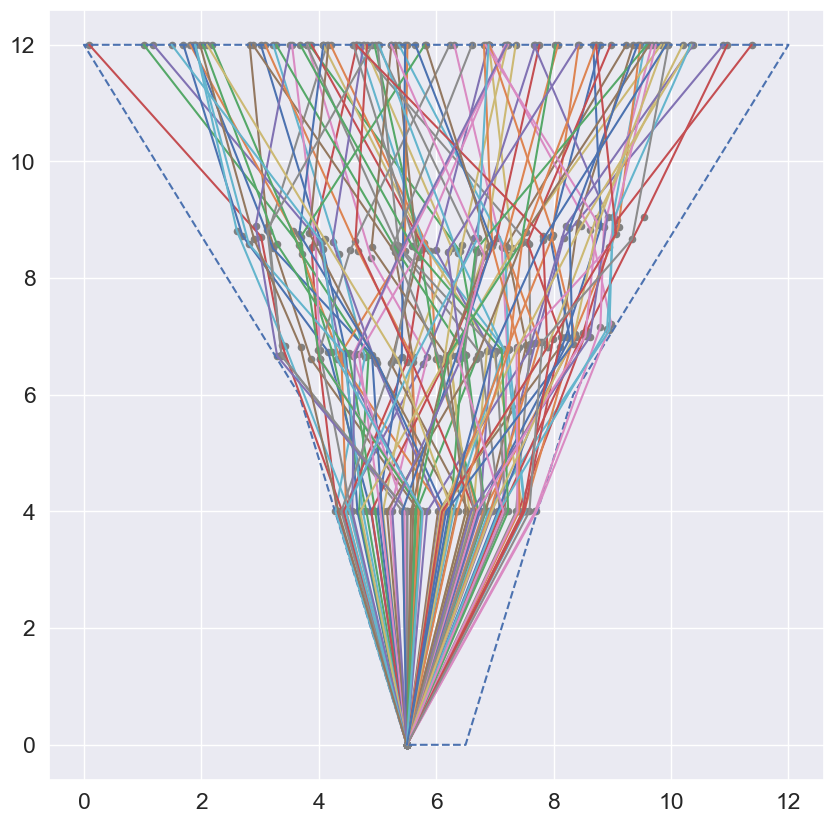

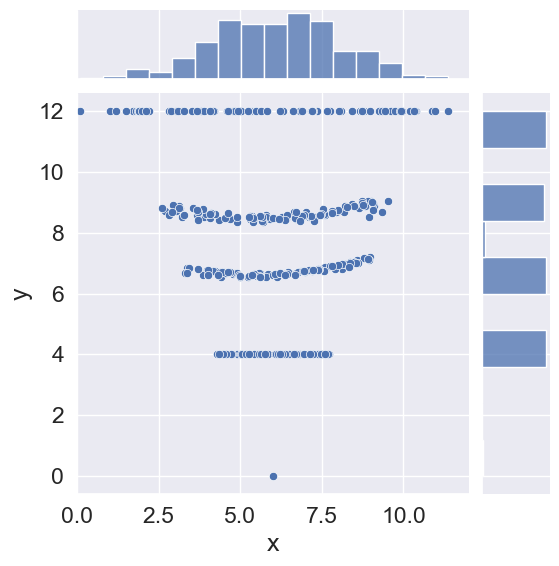

In [63]:
# Case 3.2.1: multiple source point WITHOUT ID
# Plot polygons and points
goalLine = LineString([(0, 12), (12, 12)])
sourcePoints = [Point(5.5, 0), Point(5.75, 0), Point(6, 0), Point(6.25, 0), Point(6.5, 0)]
end = Point(6, 12)
p = generic_p
nIntermediate = 3

crosswalkGeometry = CrosswalkGeometry(
            source=sourcePoints[0],
            idealDestination=None,
            areaPolygon=p,
            goalLine=goalLine
        )

# Case 3.2.1 figures
data = {'x': [], 'y': []}

p = crosswalkGeometry.areaPolygon
x,y = p.exterior.xy

plt.rcParams["figure.figsize"] = (10,10)
plt.plot(x,y, '--')
       
#plt.scatter(end.x, end.y, s=100, color='green')

maxAbsDegree = math.radians(60)
maxDeltaDegree = math.radians(45)

for i in range(100):
    line_x = []
    line_y = []
    waypoints = crosswalkGeometry.generateIntermediatePoints(maxAbsDegree, maxDeltaDegree, nIntermediate, 1.5)
    
    waypoints.insert(0, crosswalkGeometry.source)
    

    for j in range(len(waypoints)):
        line_x.append(waypoints[j].x)
        line_y.append(waypoints[j].y)

        if waypoints[j].y != start.y:
            data['x'].append(waypoints[j].x)
            data['y'].append(waypoints[j].y)

        plt.scatter(waypoints[j].x, waypoints[j].y, s=20, color='grey')
        

    plt.plot(line_x, line_y)

plt.savefig("notebooks/Crosswalk-area/figures/case_321_sc.png")
# Visualizing data
data['x'].append(start.x)
data['y'].append(start.y)
fig = sb.jointplot(data=data, x='x', y='y', xlim=[0, 12])
fig.savefig("notebooks/Crosswalk-area/figures/case_321_jp.png")



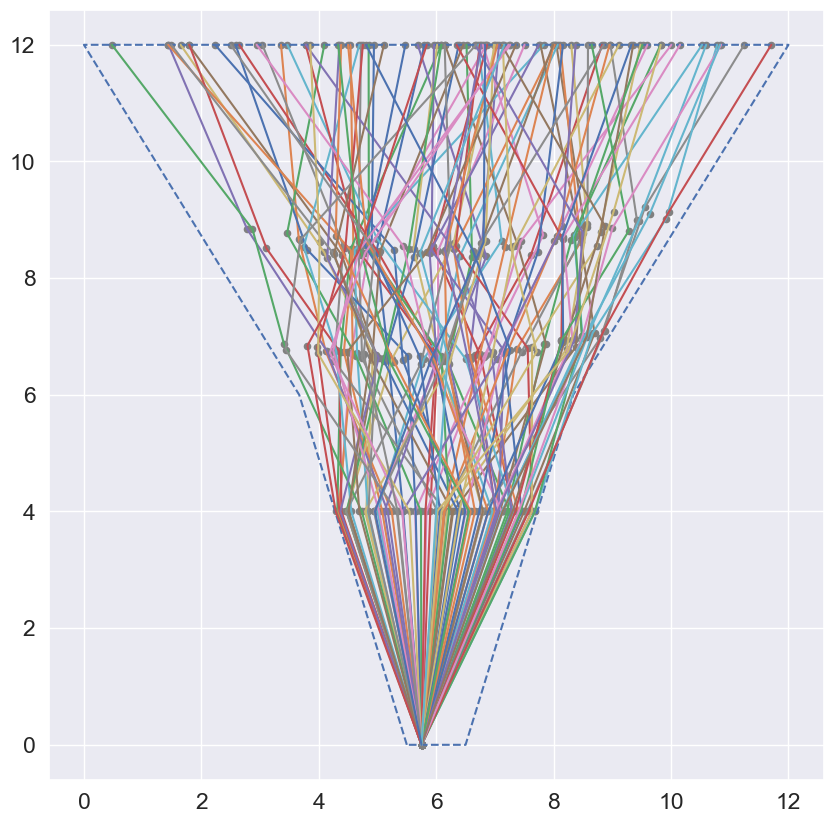

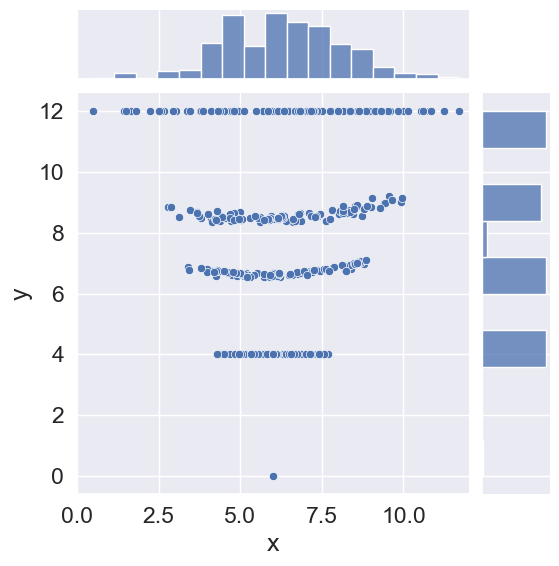

In [64]:
# Case 3.2.2: multiple source point WITHOUT ID
# Plot polygons and points
goalLine = LineString([(0, 12), (12, 12)])
sourcePoints = [Point(5.5, 0), Point(5.75, 0), Point(6, 0), Point(6.25, 0), Point(6.5, 0)]
end = Point(6, 12)
p = generic_p
nIntermediate = 3

crosswalkGeometry = CrosswalkGeometry(
            source=sourcePoints[1],
            idealDestination=None,
            areaPolygon=p,
            goalLine=goalLine
        )

# Case 3.2.2 figures
data = {'x': [], 'y': []}

p = crosswalkGeometry.areaPolygon
x,y = p.exterior.xy

plt.rcParams["figure.figsize"] = (10,10)
plt.plot(x,y, '--')
       
#plt.scatter(end.x, end.y, s=100, color='green')

maxAbsDegree = math.radians(60)
maxDeltaDegree = math.radians(45)

for i in range(100):
    line_x = []
    line_y = []
    waypoints = crosswalkGeometry.generateIntermediatePoints(maxAbsDegree, maxDeltaDegree, nIntermediate, 1.5)
    
    waypoints.insert(0, crosswalkGeometry.source)
    

    for j in range(len(waypoints)):
        line_x.append(waypoints[j].x)
        line_y.append(waypoints[j].y)

        if waypoints[j].y != start.y:
            data['x'].append(waypoints[j].x)
            data['y'].append(waypoints[j].y)

        plt.scatter(waypoints[j].x, waypoints[j].y, s=20, color='grey')
        

    plt.plot(line_x, line_y)

plt.savefig("notebooks/Crosswalk-area/figures/case_322_sc.png")
# Visualizing data
data['x'].append(start.x)
data['y'].append(start.y)
fig = sb.jointplot(data=data, x='x', y='y', xlim=[0, 12])
fig.savefig("notebooks/Crosswalk-area/figures/case_322_jp.png")



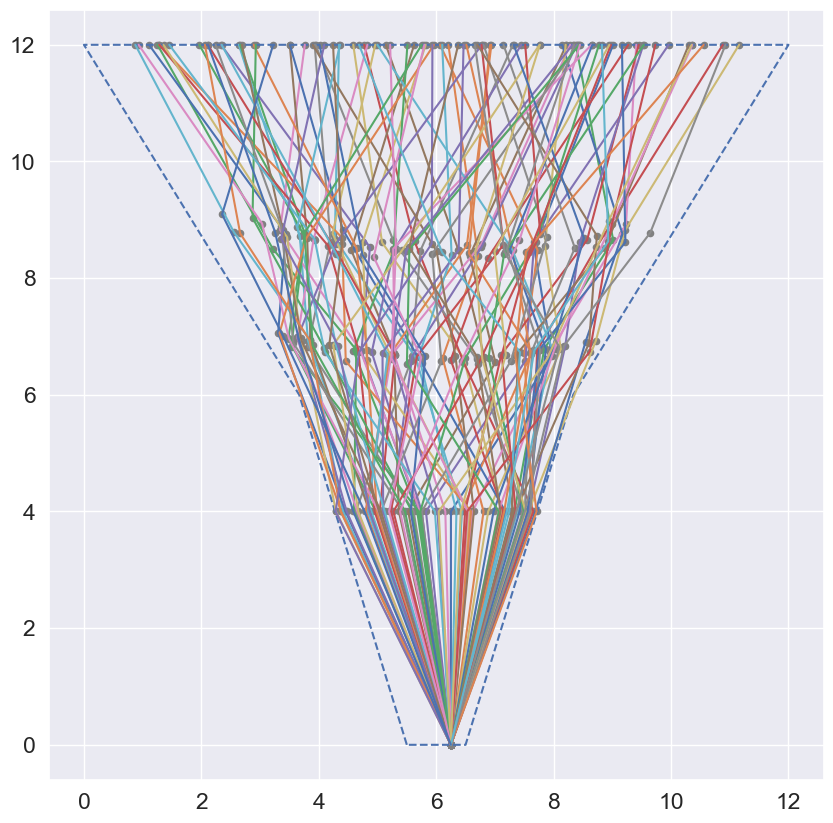

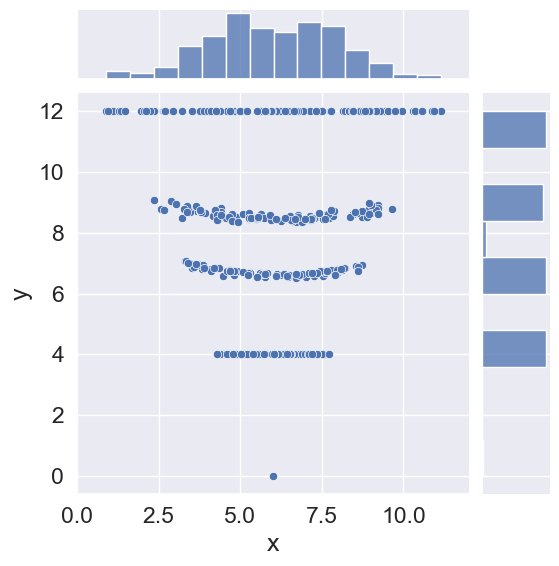

In [65]:
# Case 3.2.3: multiple source point WITHOUT ID
# Plot polygons and points
goalLine = LineString([(0, 12), (12, 12)])
sourcePoints = [Point(5.5, 0), Point(5.75, 0), Point(6, 0), Point(6.25, 0), Point(6.5, 0)]
end = Point(6, 12)
p = generic_p
nIntermediate = 3

crosswalkGeometry = CrosswalkGeometry(
            source=sourcePoints[3],
            idealDestination=None,
            areaPolygon=p,
            goalLine=goalLine
        )

# Case 3.2.3 figures
data = {'x': [], 'y': []}

p = crosswalkGeometry.areaPolygon
x,y = p.exterior.xy

plt.rcParams["figure.figsize"] = (10,10)
plt.plot(x,y, '--')
       
#plt.scatter(end.x, end.y, s=100, color='green')

maxAbsDegree = math.radians(60)
maxDeltaDegree = math.radians(45)

for i in range(100):
    line_x = []
    line_y = []
    waypoints = crosswalkGeometry.generateIntermediatePoints(maxAbsDegree, maxDeltaDegree, nIntermediate, 1.5)
    
    waypoints.insert(0, crosswalkGeometry.source)
    

    for j in range(len(waypoints)):
        line_x.append(waypoints[j].x)
        line_y.append(waypoints[j].y)

        if waypoints[j].y != start.y:
            data['x'].append(waypoints[j].x)
            data['y'].append(waypoints[j].y)

        plt.scatter(waypoints[j].x, waypoints[j].y, s=20, color='grey')
        

    plt.plot(line_x, line_y)

plt.savefig("notebooks/Crosswalk-area/figures/case_323_sc.png")
# Visualizing data
data['x'].append(start.x)
data['y'].append(start.y)
fig = sb.jointplot(data=data, x='x', y='y', xlim=[0, 12])
fig.savefig("notebooks/Crosswalk-area/figures/case_323_jp.png")



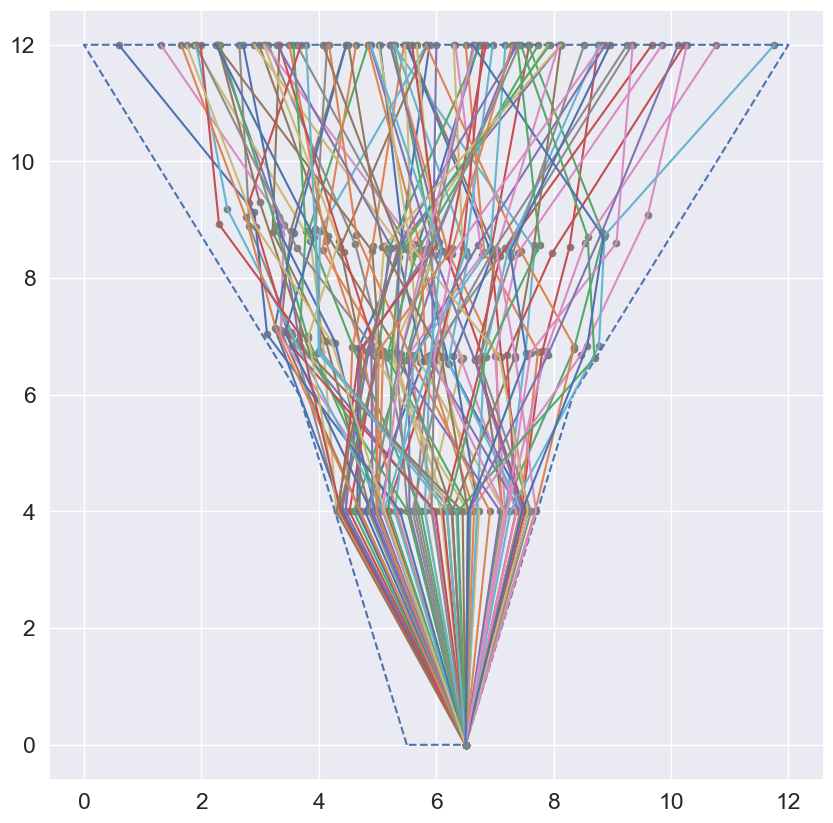

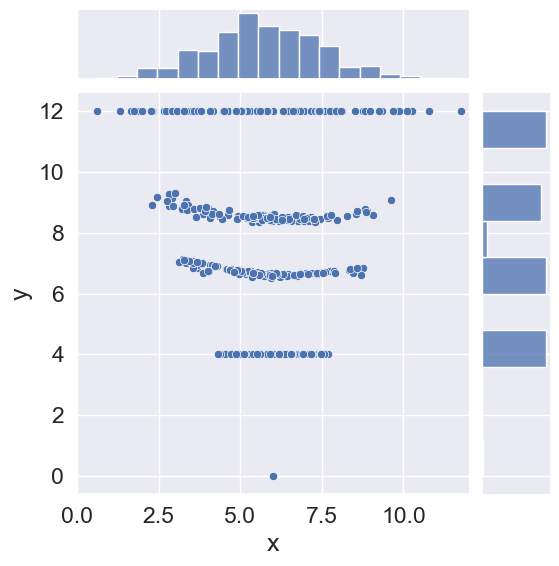

In [66]:
# Case 3.2.4: multiple source point WITHOUT ID
# Plot polygons and points
goalLine = LineString([(0, 12), (12, 12)])
sourcePoints = [Point(5.5, 0), Point(5.75, 0), Point(6, 0), Point(6.25, 0), Point(6.5, 0)]
end = Point(6, 12)
p = generic_p
nIntermediate = 3

crosswalkGeometry = CrosswalkGeometry(
            source=sourcePoints[4],
            idealDestination=None,
            areaPolygon=p,
            goalLine=goalLine
        )

# Case 3.2.4 figures
data = {'x': [], 'y': []}

p = crosswalkGeometry.areaPolygon
x,y = p.exterior.xy

plt.rcParams["figure.figsize"] = (10,10)
plt.plot(x,y, '--')
       
#plt.scatter(end.x, end.y, s=100, color='green')

maxAbsDegree = math.radians(60)
maxDeltaDegree = math.radians(45)

for i in range(100):
    line_x = []
    line_y = []
    waypoints = crosswalkGeometry.generateIntermediatePoints(maxAbsDegree, maxDeltaDegree, nIntermediate, 1.5)
    
    waypoints.insert(0, crosswalkGeometry.source)
    

    for j in range(len(waypoints)):
        line_x.append(waypoints[j].x)
        line_y.append(waypoints[j].y)

        if waypoints[j].y != start.y:
            data['x'].append(waypoints[j].x)
            data['y'].append(waypoints[j].y)

        plt.scatter(waypoints[j].x, waypoints[j].y, s=20, color='grey')
        

    plt.plot(line_x, line_y)

plt.savefig("notebooks/Crosswalk-area/figures/case_324_sc.png")
# Visualizing data
data['x'].append(start.x)
data['y'].append(start.y)
fig = sb.jointplot(data=data, x='x', y='y', xlim=[0, 12])
fig.savefig("notebooks/Crosswalk-area/figures/case_324_jp.png")



In [71]:
# Case 4.1.1: Different crosswalk area with ID
# Plot polygons and points

polygons = {"5.0": [[[-0.8493564206776597, 1.0], [-1.69111385831398, 2.0], [-2.315485015381113, 3.0], [-2.8998445021191133, 4.0], [-3.329996733382468, 5.0], [3.179880832919363, 5.0], [2.8579449043879515, 4.0], [2.407998876533319, 3.0], [1.8191770139055718, 2.0], [1.0923319480181632, 1.0], [-0.8493564206776597, 1.0]], [[0.17550241711354664, 1.0], [0.5932530309594908, 2.0], [1.1703443796281663, 3.0], [1.688172759476259, 4.0], [3.969402166525618, 5.0], [4.163426991106638, 5.0], [1.7527670105562525, 4.0], [1.2982975058391748, 3.0], [0.62844102754201, 2.0], [0.21048587411035014, 1.0], [0.17550241711354664, 1.0]]], "9.0": [[[-0.41374192554544376, 1.0], [-0.12175127345425274, 2.0], [0.4379053601341596, 3.0], [1.0001437331726877, 4.0], [1.3989329344162122, 5.0], [1.6242885571966426, 6.0], [1.8427370994859213, 7.0], [2.261074977665251, 8.0], [2.6342552510500847, 9.0], [11.978330982467018, 9.0], [9.242667289512717, 8.0], [7.9410026387656485, 7.0], [6.529691205716137, 6.0], [5.421111066704853, 5.0], [4.840944594280318, 4.0], [4.189429048085943, 3.0], [3.3998644585144078, 2.0], [2.593056063800949, 1.0], [-0.41374192554544376, 1.0]]], "6.0": [[[-0.04379866275952693, 1.0], [0.1392774027998387, 2.0], [0.11232926309717928, 3.0], [0.08362071743614408, 4.0], [-0.025493044881786275, 5.0], [-0.2596540243344858, 6.0], [6.124331131277936, 6.0], [4.810796759574492, 5.0], [4.133177762335055, 4.0], [2.601473983049212, 3.0], [2.006487560127159, 2.0], [1.3391571002315772, 1.0], [-0.04379866275952693, 1.0]], [[-0.7840894965588592, 1.0], [-1.527932577432889, 2.0], [-2.3447542901070735, 3.0], [-3.2895142966539876, 4.0], [-4.284902413230908, 5.0], [-5.2184637903923985, 6.0], [5.254372472034417, 6.0], [3.7896178561042264, 5.0], [2.8387032358790076, 4.0], [2.1468062200572158, 3.0], [1.6182939774434928, 2.0], [0.9637181447460508, 1.0], [-0.7840894965588592, 1.0]], [[-0.35403559323107503, 1.0], [-0.6349895672795756, 2.0], [-0.8943569063887107, 3.0], [-1.1771108033399367, 4.0], [-1.3643359057735231, 5.0], [-1.450887893345346, 6.0], [4.607294970255896, 6.0], [5.068896784716372, 5.0], [4.291985868250096, 4.0], [3.389357755785891, 3.0], [2.4978911227391567, 2.0], [1.4704225783642637, 1.0], [-0.35403559323107503, 1.0]]]}

serial = "6.0"
code = 0
a = polygons[serial][code]

polyPoints = []
gL1 = [0,0]
gL2 = [0,0]
c = 0
for i in range(len(a)):
    polyPoints.append(Point((a[i][0], a[i][1])))
    if a[i][1] == float(serial) and c == 0:
        gL1[0] = a[i][0]
        gL1[1] = a[i][1]
        c += 1
    if a[i][1] == float(serial) and c != 0:
        gL2[0] = a[i][0]
        gL2[1] = a[i][1]
    
p = Polygon(polyPoints)
bounds = p.bounds
print(bounds)


   
start = Point(0, 1)

end = Point((gL1[0] + gL2[0]) / 2, gL1[1])

goalLine = LineString([gL1, gL2])

nIntermediate = 3

crosswalkGeometry = CrosswalkGeometry(
            source=start,
            idealDestination=end,
            areaPolygon=p,
            goalLine=goalLine
        )




(-0.2596540243344858, 1.0, 6.124331131277936, 6.0)


In [ ]:

# Case 4.1.1 figures
data = {'x': [], 'y': []}

p = crosswalkGeometry.areaPolygon
x,y = p.exterior.xy

plt.rcParams["figure.figsize"] = (10,10)
plt.plot(x,y, '--')
       
plt.scatter(end.x, end.y, s=100, color='green')

maxAbsDegree = math.radians(60)
maxDeltaDegree = math.radians(45)

for i in range(100):
    line_x = []
    line_y = []
    waypoints = crosswalkGeometry.generateIntermediatePoints(maxAbsDegree, maxDeltaDegree, nIntermediate, 1.5)
    
    waypoints.insert(0, crosswalkGeometry.source)
    

    for j in range(len(waypoints)):
        line_x.append(waypoints[j].x)
        line_y.append(waypoints[j].y)

        if waypoints[j].y != start.y:
            data['x'].append(waypoints[j].x)
            data['y'].append(waypoints[j].y)

        plt.scatter(waypoints[j].x, waypoints[j].y, s=20, color='grey')
        

    plt.plot(line_x, line_y)

#plt.savefig("notebooks/Crosswalk-area/figures/case_324_sc.png")
# Visualizing data
data['x'].append(start.x)
data['y'].append(start.y)
fig = sb.jointplot(data=data, x='x', y='y', xlim=[0, 12])
#fig.savefig("notebooks/Crosswalk-area/figures/case_324_jp.png")